In [1]:
!pip install pmdarima

In [2]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import warnings

In [3]:
from math import sqrt
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

In [4]:
warnings.filterwarnings("ignore")

In [5]:
df = pd.read_csv('../../data/sensor1.csv')

In [6]:
df = df.dropna()

In [7]:
units_dict = {}

for col in df.columns[1:]:
    values = []
    units = set()
    for val in df[col]:
        value, unit = val.split()
        values.append(value)
        units.add(unit)
    new_col_name = f"{col} ({units.pop()})"
    df.rename(columns={col: new_col_name}, inplace=True)
    df[new_col_name] = pd.to_numeric(values)
    units_dict[col] = units

In [8]:
df['Time'] = pd.to_datetime(df['Time'])

In [9]:
df.index = df['Time']
df.drop(columns=['Time'], inplace=True)

In [10]:
df = df.sort_index()

In [11]:
humidity = df["Humidity (%H)"]

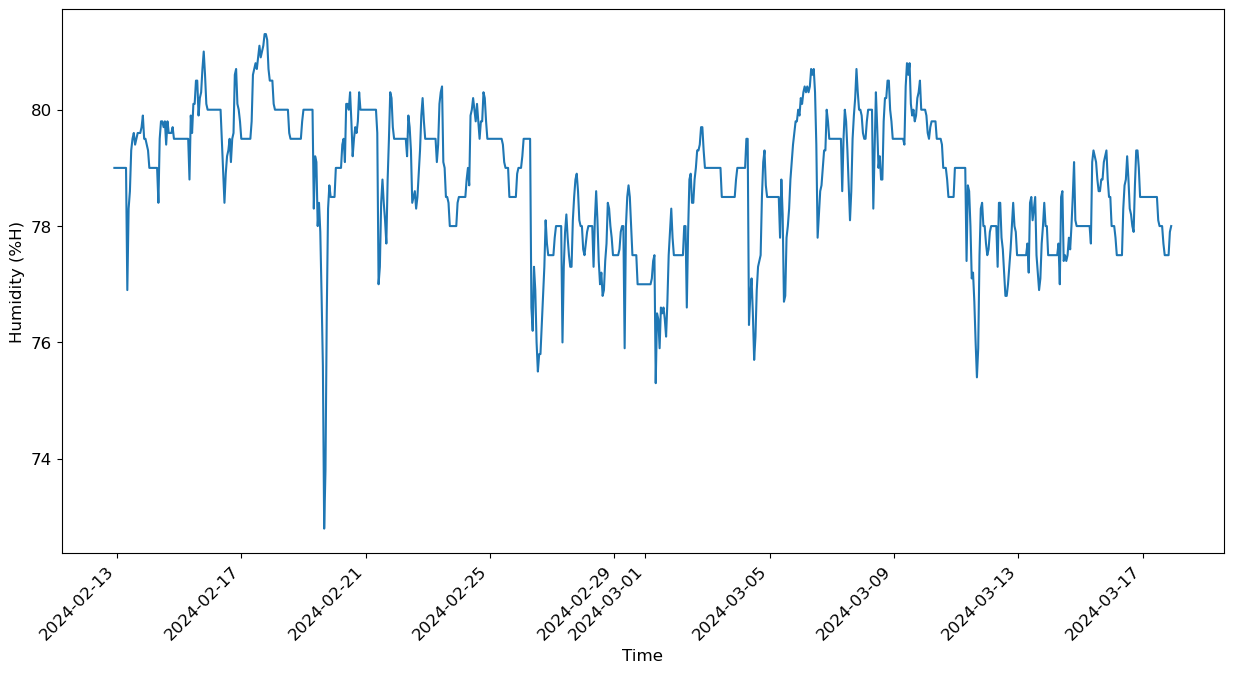

In [12]:
humidity.plot(y='Humidity (%H)', subplots=True, figsize=(15, 8), fontsize=12)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Humidity (%H)', fontsize=12)
plt.xticks(rotation=45)
plt.show()

Create training and testing datasets

In [13]:
train_size = int(0.8 * len(df))

In [14]:
train_df = df.iloc[:train_size]
test_df = df.iloc[train_size:]

In [15]:
train_start_dt = train_df.index[0]
test_start_dt = test_df.index[0]

In [16]:
train_start_dt, test_start_dt

(Timestamp('2024-02-12 22:00:00'), Timestamp('2024-03-11 04:00:00'))

In [17]:
df

,CO2 (ppm),Humidity (%H),PM10 (μg/m³),PM2.5 (μg/m³),Temperature (°C),TVOC (ppm)
Time,,,,,,
2024-02-12 22:00:00,456,79.0,5.60,5.60,24.0,0.642
2024-02-12 23:00:00,456,79.0,5.25,5.13,24.1,0.711
2024-02-13 00:00:00,456,79.0,6.00,5.89,24.2,0.744
2024-02-13 01:00:00,450,79.0,6.44,6.33,24.2,0.759
2024-02-13 02:00:00,447,79.0,6.25,5.88,24.3,0.775
...,...,...,...,...,...,...
2024-03-17 18:00:00,435,77.5,19.00,18.70,25.4,0.468
2024-03-17 19:00:00,433,77.5,19.50,18.80,25.3,0.437
2024-03-17 20:00:00,429,77.5,18.80,18.20,25.3,0.442


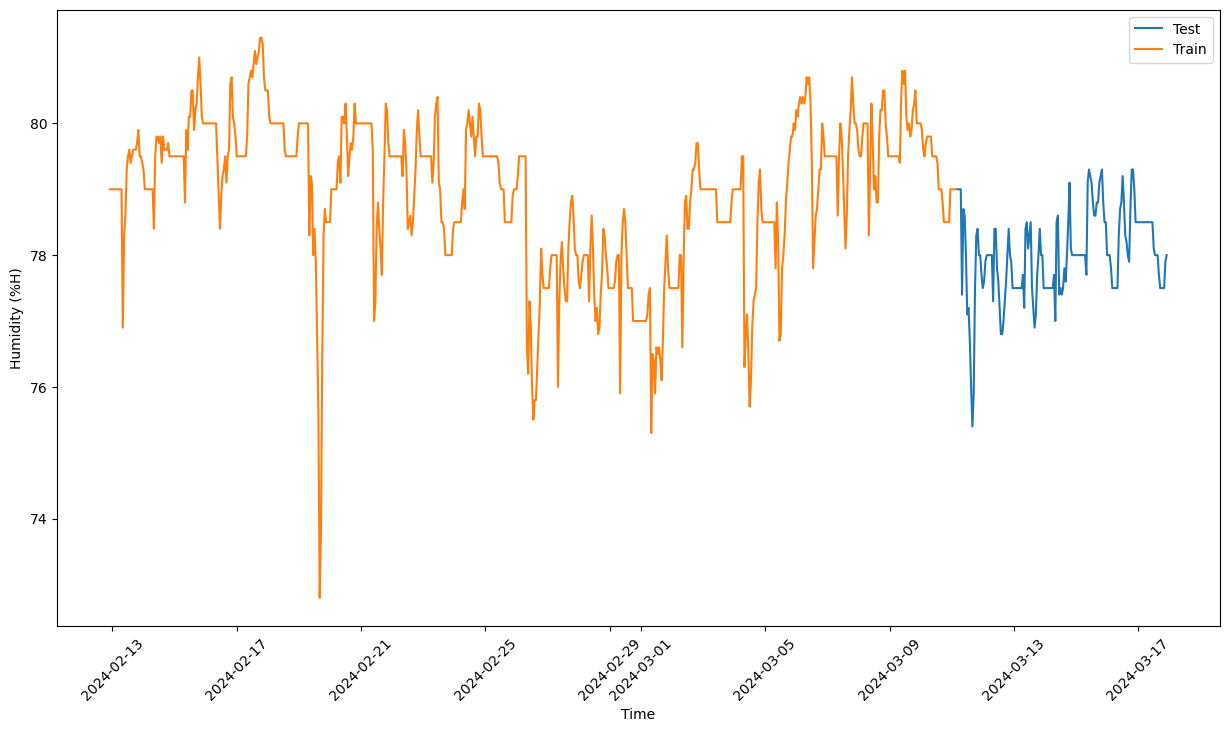

In [18]:
test_humidity = df[df.index >= test_start_dt]["Humidity (%H)"]
train_humidity = df[(df.index < test_start_dt) & (df.index >= train_start_dt)]["Humidity (%H)"]

plt.figure(figsize=(15, 8))
plt.plot(test_humidity.index, test_humidity.values, label='Test')

plt.plot(train_humidity.index, train_humidity.values, label='Train')

plt.xlabel('Time')
plt.ylabel('Humidity (%H)')
plt.xticks(rotation=45)
plt.legend()
plt.show()

Data preparation

In [19]:
train_humidity_reshaped = train_humidity.values.reshape(-1, 1)
test_humidity_reshaped = test_humidity.values.reshape(-1, 1)

In [20]:
print("Training data shape: ", train_humidity_reshaped.shape)
print("Test data shape: ", test_humidity_reshaped.shape)

Training data shape:  (652, 1)
Test data shape:  (163, 1)


In [21]:
scaler = MinMaxScaler()
train_humidity_scaled = scaler.fit_transform(train_humidity_reshaped)
train_humidity_scaled = pd.DataFrame(train_humidity_scaled.flatten(), index=train_humidity.index, columns=["Humidity (%H)"])
train_humidity_scaled.head(10)

,Humidity (%H)
Time,
2024-02-12 22:00:00,0.729412
2024-02-12 23:00:00,0.729412
2024-02-13 00:00:00,0.729412
2024-02-13 01:00:00,0.729412
2024-02-13 02:00:00,0.729412
2024-02-13 03:00:00,0.729412
2024-02-13 04:00:00,0.729412
2024-02-13 05:00:00,0.729412
2024-02-13 06:00:00,0.729412


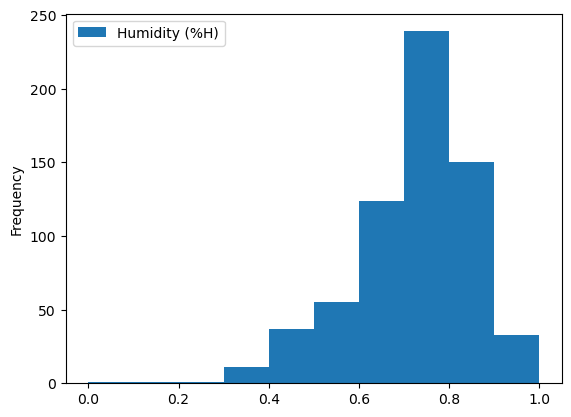

In [22]:
train_humidity_scaled.plot.hist(bins=10)
plt.show()

In [23]:
test_humidity_scaled = scaler.fit_transform(test_humidity_reshaped)
test_humidity_scaled = pd.DataFrame(test_humidity_scaled.flatten(), index=test_humidity.index, columns=["Humidity (%H)"])
test_humidity_scaled.head(10)

,Humidity (%H)
Time,
2024-03-11 04:00:00,0.923077
2024-03-11 05:00:00,0.923077
2024-03-11 06:00:00,0.923077
2024-03-11 07:00:00,0.923077
2024-03-11 08:00:00,0.512821
2024-03-11 09:00:00,0.846154
2024-03-11 10:00:00,0.820513
2024-03-11 11:00:00,0.666667
2024-03-11 12:00:00,0.435897


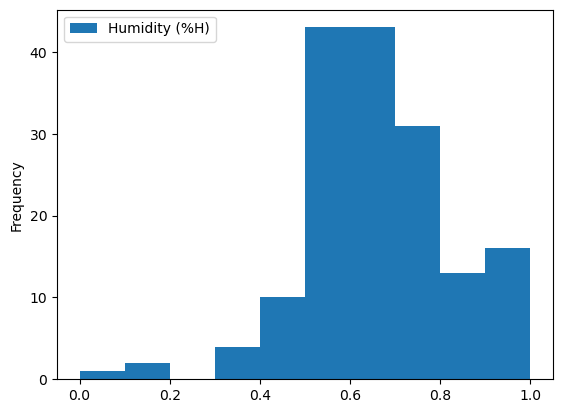

In [24]:
test_humidity_scaled.plot.hist(bins=10)
plt.show()

In [25]:
HORIZON_HUMIDITY = 1

In [26]:
stepwise_fit_humidity = auto_arima(train_humidity_scaled, trace=True, suppress_warnings=True)
stepwise_fit_humidity.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-1884.830, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1846.854, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1845.509, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1845.822, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1848.854, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-1886.211, Time=0.44 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-1863.772, Time=0.27 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1877.365, Time=0.37 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-1886.183, Time=1.61 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-1866.881, Time=0.41 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-1884.251, Time=1.41 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-1880.308, Time=3.66 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-1888.211, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-1865.772, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  652
Model:               SARIMAX(1, 1, 3)   Log Likelihood                 949.494
Date:                Sun, 17 Mar 2024   AIC                          -1888.987
Time:                        22:23:56   BIC                          -1866.595
Sample:                             0   HQIC                         -1880.302
                                - 652                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8368      0.036     23.051      0.000       0.766       0.908
ma.L1         -0.8550      0.042    -20.155      0.000      -0.938      -0.772
ma.L2         -0.2004      0.037     -5.399      0.000      -0.273      -0.128
ma.L3          0.0854      0.042      2.052      0.040       0.004       0.167
sigma2         0.0032   6.85e-05     46.184      0.000       0.003       0.003
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              4057.61
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.76   Skew:                            -1.85
Prob(H) (two-sided):                  0.04   Kurtosis:                        14.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [27]:
order_humidity = (1,1,3)

In [28]:
model_humidity =  ARIMA(endog=train_humidity_scaled, order=order_humidity)
result_humidity = model_humidity.fit()

print(result_humidity.summary())

                               SARIMAX Results                                
Dep. Variable:          Humidity (%H)   No. Observations:                  652
Model:                 ARIMA(1, 1, 3)   Log Likelihood                 949.494
Date:                Sun, 17 Mar 2024   AIC                          -1888.987
Time:                        22:23:59   BIC                          -1866.595
Sample:                             0   HQIC                         -1880.302
                                - 652                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8368      0.036     23.051      0.000       0.766       0.908
ma.L1         -0.8550      0.042    -20.155      0.000      -0.938      -0.772
ma.L2         -0.2004      0.037     -5.399      0.0

Walk-forward validation

Create a test data point for each HORIZON.<br>
Shift the data horizontally according to its horizon point.

In [29]:
test_humidity_shifted = test_humidity_scaled.copy()

for t in range(1, HORIZON_HUMIDITY):
    test_humidity_shifted["Humidity (%H)+" + str(t)] = test_humidity_shifted["Humidity (%H)"].shift(-t, freq='H')
    
test_humidity_shifted = test_humidity_shifted.dropna(how='any')
test_humidity_shifted.head()

,Humidity (%H)
Time,
2024-03-11 04:00:00,0.923077
2024-03-11 05:00:00,0.923077
2024-03-11 06:00:00,0.923077
2024-03-11 07:00:00,0.923077
2024-03-11 08:00:00,0.512821


Make predictions on the test data using a sliding window approach in a loop the size of the test data length.

In [30]:
stepwise_fit_humidity_test = auto_arima(test_humidity_scaled, trace=True, suppress_warnings=True)
stepwise_fit_humidity_test.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.52 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-248.091, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-246.144, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-246.159, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-250.058, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.881 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  163
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 126.029
Date:                Sun, 17 Mar 2024   AIC                           -250.058
Time:                        22:24:00   BIC                           -246.971
Sample:                    03-11-2024   HQIC                          -248.805
                         - 03-17-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0124      0.001     14.879      0.000       0.011       0.014
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                90.56
Prob(Q):                              0.82   Prob(JB):                         0.00
Heteroskedasticity (H):               0.26   Skew:                             0.54
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [31]:
test_humidity_shifted

,Humidity (%H)
Time,
2024-03-11 04:00:00,0.923077
2024-03-11 05:00:00,0.923077
2024-03-11 06:00:00,0.923077
2024-03-11 07:00:00,0.923077
2024-03-11 08:00:00,0.512821
...,...
2024-03-17 18:00:00,0.538462
2024-03-17 19:00:00,0.538462
2024-03-17 20:00:00,0.538462


In [32]:
%%time
training_window = 168

train_ts_humidity = train_humidity_scaled["Humidity (%H)"]
test_ts_humidity = test_humidity_shifted

history_humidity = [x for x in train_ts_humidity]
history_humidity = history_humidity[(-training_window):]

predictions_humidity = list()

# order = (2,1,1)

for t in range(test_ts_humidity.shape[0]):
    model_humidity = ARIMA(endog=history_humidity, order=order_humidity)
    model_fit_humidity = model_humidity.fit()
    yhat = model_fit_humidity.forecast(steps = HORIZON_HUMIDITY)
    predictions_humidity.append(yhat)
    obs = list(test_ts_humidity.iloc[t])
    # move the training window
    history_humidity.append(obs[0])
    history_humidity.pop(0)
    print(test_ts_humidity.index[t])
    print(t+1, ': predicted =', yhat, 'expected =', obs)

2024-03-11 04:00:00
1 : predicted = [0.72840346] expected = [0.9230769230769234]
2024-03-11 05:00:00
2 : predicted = [0.94738294] expected = [0.9230769230769234]
2024-03-11 06:00:00
3 : predicted = [0.86806312] expected = [0.9230769230769234]
2024-03-11 07:00:00
4 : predicted = [0.91909931] expected = [0.9230769230769234]
2024-03-11 08:00:00
5 : predicted = [0.91891253] expected = [0.5128205128205146]
2024-03-11 09:00:00
6 : predicted = [0.4427674] expected = [0.8461538461538467]
2024-03-11 10:00:00
7 : predicted = [0.93638689] expected = [0.8205128205128212]
2024-03-11 11:00:00
8 : predicted = [0.74421443] expected = [0.6666666666666679]
2024-03-11 12:00:00
9 : predicted = [0.74729353] expected = [0.43589743589743435]
2024-03-11 13:00:00
10 : predicted = [0.48685831] expected = [0.46153846153846345]
2024-03-11 14:00:00
11 : predicted = [0.53453338] expected = [0.3333333333333357]
2024-03-11 15:00:00
12 : predicted = [0.38347286] expected = [0.1538461538461533]
2024-03-11 16:00:00
13 :

Compare the prediction against the actual Humidity.

In [33]:
eval_df_humidity = pd.DataFrame(predictions_humidity, columns=['t+'+str(t) for t in range(1, HORIZON_HUMIDITY+1)])
eval_df_humidity['Time'] = test_humidity_scaled.index[0:len(test_humidity_scaled.index)-HORIZON_HUMIDITY+1]
eval_df_humidity = pd.melt(eval_df_humidity, id_vars='Time', value_name='Prediction', var_name='H')
eval_df_humidity['Actual'] = np.array(np.transpose(test_ts_humidity)).ravel()
eval_df_humidity[['Prediction', 'Actual']] = scaler.inverse_transform(eval_df_humidity[['Prediction', 'Actual']])
eval_df_humidity.head()

,Time,H,Prediction,Actual
0,2024-03-11 04:00:00,t+1,78.240774,79.0
1,2024-03-11 05:00:00,t+1,79.094793,79.0
2,2024-03-11 06:00:00,t+1,78.785446,79.0
3,2024-03-11 07:00:00,t+1,78.984487,79.0
4,2024-03-11 08:00:00,t+1,78.983759,77.4


Check the model accuracy by testing its mean absolute percentage error (MAPE) over all the predictions.

In [34]:
if (HORIZON_HUMIDITY > 1):
    eval_df_humidity['APE'] = (eval_df_humidity['Prediction'] - eval_df_humidity['Actual']).abs()
    print(eval_df_humidity.groupby('H')['APE'].mean())

In [35]:
# Mean absolute percentage error
def mape(predictions, actuals):
    predictions = np.array(predictions)
    actuals = np.array(actuals)
    return (np.absolute(predictions - actuals) / actuals).mean()

In [36]:
print('Multi-step forecast MAPE: ', mape(eval_df_humidity['Prediction'], eval_df_humidity['Actual'])*100, '%')

Multi-step forecast MAPE:  0.3572313370906865 %


In [37]:
rmse_humidity = sqrt(mean_squared_error(eval_df_humidity['Prediction'], eval_df_humidity['Actual']))
rmse_humidity

0.4375111851207333

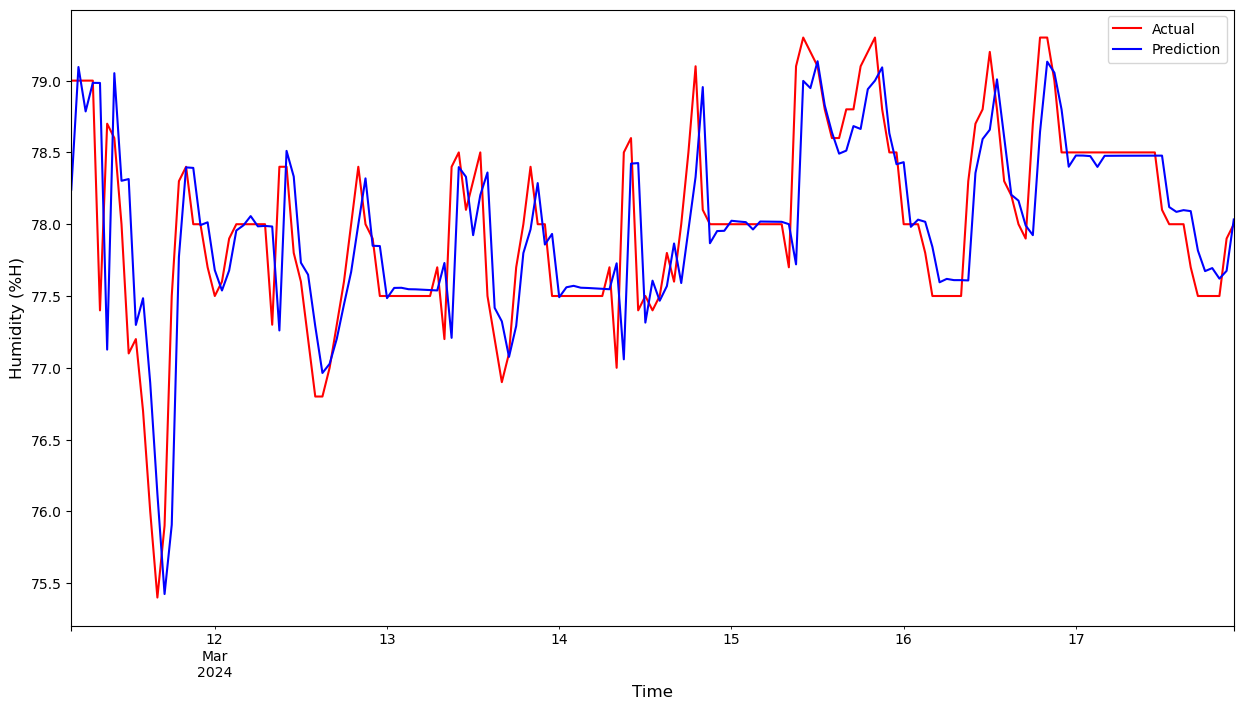

In [38]:
if HORIZON_HUMIDITY == 1:
    eval_df_humidity.plot(x='Time', y=['Actual', 'Prediction'], style=['r', 'b'], figsize=(15, 8))
    plt.xlabel('Time', fontsize=12)
    plt.ylabel('Humidity (%H)', fontsize=12)
    plt.legend(['Actual', 'Prediction'], loc='best')
    plt.show()
else:
    plot_df_humidity = eval_df_humidity[(eval_df_humidity.H == 't+1')][['Time', 'Actual']]
    for t in range(1, HORIZON_HUMIDITY + 1):
        plot_df_humidity['t+' + str(t)] = eval_df_humidity[(eval_df_humidity.H == 't+' + str(t))]['Prediction'].values

    fig = plt.figure(figsize=(15, 8))
    ax = fig.add_subplot(111)
    ax.plot(plot_df_humidity['Time'], plot_df_humidity['Actual'], color='red', linewidth=4.0, label='Actual')
    for t in range(1, HORIZON_HUMIDITY + 1):
        x = plot_df_humidity['Time'][(t - 1):]
        y = plot_df_humidity['t+' + str(t)][0:len(x)]
        ax.plot(x, y, color='blue', linewidth=4 * math.pow(.9, t), alpha=math.pow(0.8, t),
                label='Prediction t+' + str(t))

    ax.legend(loc='best')
    plt.xlabel('Time', fontsize=12)
    plt.ylabel('Humidity (%H)', fontsize=12)
    plt.show()

In [39]:
next_hour = pd.date_range(start=df.index[-1], periods=2, freq='H')[-1]

In [40]:
pred_humidity = model_fit_humidity.predict(start=len(df), end=len(df), typ="levels")[0]
pred_humidity_nonscaled = round(scaler.inverse_transform(np.array(pred_humidity).reshape(-1, 1))[0][0], 1)
print(f"{next_hour} {pred_humidity_nonscaled}")

2024-03-17 23:00:00 78.2
